事先上传整个项目目录到 Google Drive（云盘）上，在开始运行程序前授权并挂载自己的云盘，使得项目可以加载自己定义类库。

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


切换到项目目录下。

In [20]:
%cd "/content/drive/My Drive/深度神经网络 For 图像二分类/"

/content/drive/My Drive/深度神经网络 For 图像二分类


查看项目目录下的文件。

In [21]:
!ls

 datasets	       images	     构建深度神经网络的辅助函数.ipynb
 dnn_app_utils_v3.py   __pycache__  '深度神经网络 For 图像二分类.ipynb'


将当前路径加载到 Python 解释器中，用于加载自己预先定义到的类库。

In [22]:
import sys
sys.path.append(".")

## Table of Contents
- [1 - Packages](#1)
- [2 - 数据集的加载和处理](#2)
- [3 - L 层深度神经网络](#3)
    - [3.1 - 构建模型](#3-1)
    - [3.2 - 训练模型](#3-2)
- [4 - 结果分析](#4)
- [5 - 自测](#5)

<a name='1'></a>
## 1 - Packages
起始步骤，导入在任务中所需的所有 Python 包（Packages）。

- [numpy](https://www.numpy.org/) ：Python 科学计算的基础包。
- [matplotlib](http://matplotlib.org) ：用于在 Python 中绘制图形的库。
- [h5py](http://www.h5py.org) ：用于与存储在 H5 文件上的数据集进行交互。
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) ：在这里使用 PIL 和 scipy 来测试模型效果，最后使用自己的图片测试。
- `dnn_app_utils` ：用于逐步构建深度神经网络的基础函数。
- `np.random.seed(1)` ：用于保持所有随机函数调用的一致性，有助于对比评估工作。

In [23]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import * # 加载自己事先定义好的类库，这个库是用于构建深度神经网络的辅助函数库。

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # 绘图的默认大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name='2'></a>
## 2 - 数据集的加载和处理

使用 "Cat vs non-Cat" 猫的二分类数据集进行练习，

**问题描述**: 数据集合 "data.h5" 包含:

    - 训练集：`m_train` 张图像，标记为 cat (1) 或者 non-cat (0)
    - 测试集：`m_test` 张图像，标记为 cat 或者 non-cat
    - 每张图像的形状为 (num_px, num_px, 3) ，3 代表图像的三个颜色通道(RGB).

通过运行下面的单元格加载数据，来熟悉下数据集。

In [24]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 1. It's a cat picture.


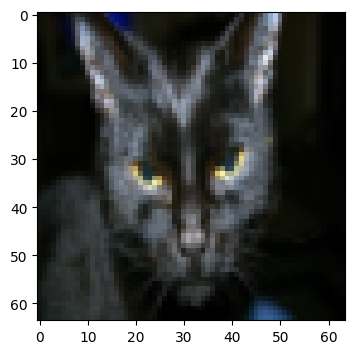

In [28]:
# 图像示例
index = 25
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [29]:
# 检查一下导入的数据情况

m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


数据预处理：在将图像输入网络之前，对其进行重塑和标准化，码如下所示。

In [30]:
# Reshape the training and test examples
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # 这里的 -1 表示将剩下的维度全部展平。
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# 数据标准化到 0 到 1 之间。
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


**Note**:
$12,288$ 等于 $64 \times 64 \times 3$, 为 reshape 后的图像尺寸.

<a name='3'></a>
## 3 - L 层神经网络

<a name='3-1'></a>
### 3.1 - 构建模型

使用一些预定义好的辅助函数来实现一个 L 层神经网络:
*[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. 函数形式如下:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [31]:
### 常数设置 ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [32]:
# 函数集成: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    实现一个 L 层神经网络: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.

    Arguments:
    X               -- 输入数据，维度形状为 (n_x, number of examples)
    Y               -- 1 或 0 的标签，1 代表图片为 cat，0 代表图片为 non-cat，维度形状为 (1, number of examples)
    layers_dims     -- 依次包含输入维度大小以及每一层网络层的维度大小，长度为 L + 1。
    learning_rate   -- 学习率，用于控制梯度更新速率。
    num_iterations  -- 模型训练迭代次数，或者说迭代轮数。
    print_cost      -- 为 True 时，每迭代 100 次打印一次 Cost 结果。

    Returns:
    parameters      -- 模型学习到的参数，用于进行预测。
    """

    np.random.seed(1)
    costs = []  # 用于跟踪每次迭代的 Cost 变化

    # 初始化参数。
    parameters = initialize_parameters_deep(layers_dims)

    # 梯度下降的迭代循环。
    for i in range(0, num_iterations):

        # 前向传播: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)

        # cost 计算.
        cost = compute_cost(AL, Y)

        # 反向传播。
        grads = L_model_backward(AL, Y, caches)

        # 参数更新。
        parameters = update_parameters(parameters, grads, learning_rate)

        # 每 100 次迭代打印一次 cost 结果。
        if i % 100 == 0 or i == num_iterations - 1:
            costs.append(cost)

            if print_cost:
                print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))

    return parameters, costs

In [33]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 1, print_cost = False)

print("Cost after first iteration: " + str(costs[0]))

Cost after first iteration: 0.7717493284237686


<a name='3-2'></a>
### 3.2 - 训练模型

如果上一个单元格代码运行正常，请运行下面的单元格来训练一个 4 层神经网络。

- 每次迭代后 Cost 应该降低。

- 运行 2500 次迭代可能需要最多 5 分钟。

In [34]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6720534400822914
Cost after iteration 200: 0.6482632048575212
Cost after iteration 300: 0.6115068816101354
Cost after iteration 400: 0.5670473268366112
Cost after iteration 500: 0.5401376634547801
Cost after iteration 600: 0.5279299569455267
Cost after iteration 700: 0.46547737717668514
Cost after iteration 800: 0.369125852495928
Cost after iteration 900: 0.39174697434805344
Cost after iteration 1000: 0.3151869888600617
Cost after iteration 1100: 0.2726998441789385
Cost after iteration 1200: 0.23741853400268137
Cost after iteration 1300: 0.19960120532208647
Cost after iteration 1400: 0.18926300388463305
Cost after iteration 1500: 0.1611885466582775
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.13777487812972944
Cost after iteration 1800: 0.12974017549190123
Cost after iteration 1900: 0.12122535068005211
Cost after iteration 2000: 0.11382060668633713
Cost after iteration 2100: 0.10783928

**预期输出**:
<table>
    <tr>
        <td> <b>迭代 0 次后的 Cost</b></td>
        <td> 0.771749 </td>
    </tr>
    <tr>
        <td> <b>迭代 100 次后的 Cost</b></td>
        <td> 0.672053 </td>
    </tr>
    <tr>
        <td> <b>...</b></td>
        <td> ... </td>
    </tr>
    <tr>
        <td> <b>迭代 2499 次后的 Cost</b></td>
        <td> 0.088439 </td>
    </tr>
</table>

In [35]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


**预期输出**:

<table>
    <tr>
    <td>
        <b>Train Accuracy:</b>
    </td>
    <td>
    0.985645933014
    </td>
    </tr>
</table>

In [36]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


**预期输出**:

<table>
    <tr>
    <td>
        <b>Test Accuracy:</b>
    </td>
    <td>
    0.8
    </td>
    </tr>
</table>

<a name='4'></a>
##  4 - 结果分析

首先，看一下 L 层模型标记错误的一些图像，展示如下：

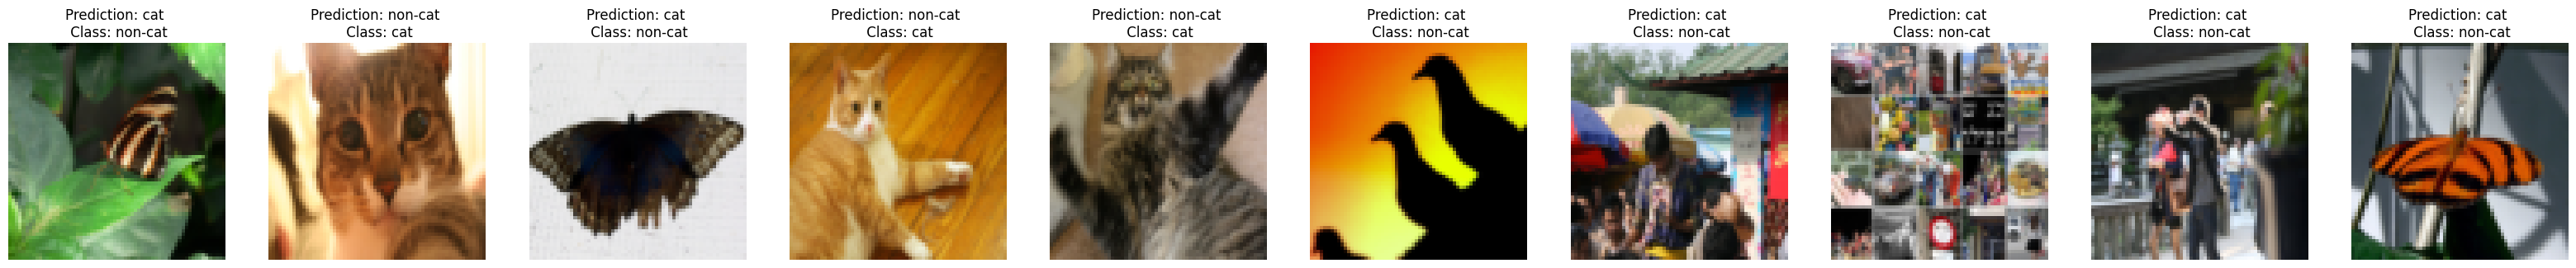

In [16]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**模型在一些类型的图像上表现不佳，比如：**
- 猫的身体处于一个不常见的位置
- 猫出现在相近的背景颜色中
- 不常见的猫的颜色和品种
- 拍摄角度问题
- 图片亮度问题
- 尺度变化问题（图像中的猫非常大或非常小）

<a name='5'></a>
## 5 - 使用自己的图像进行测试 ##

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


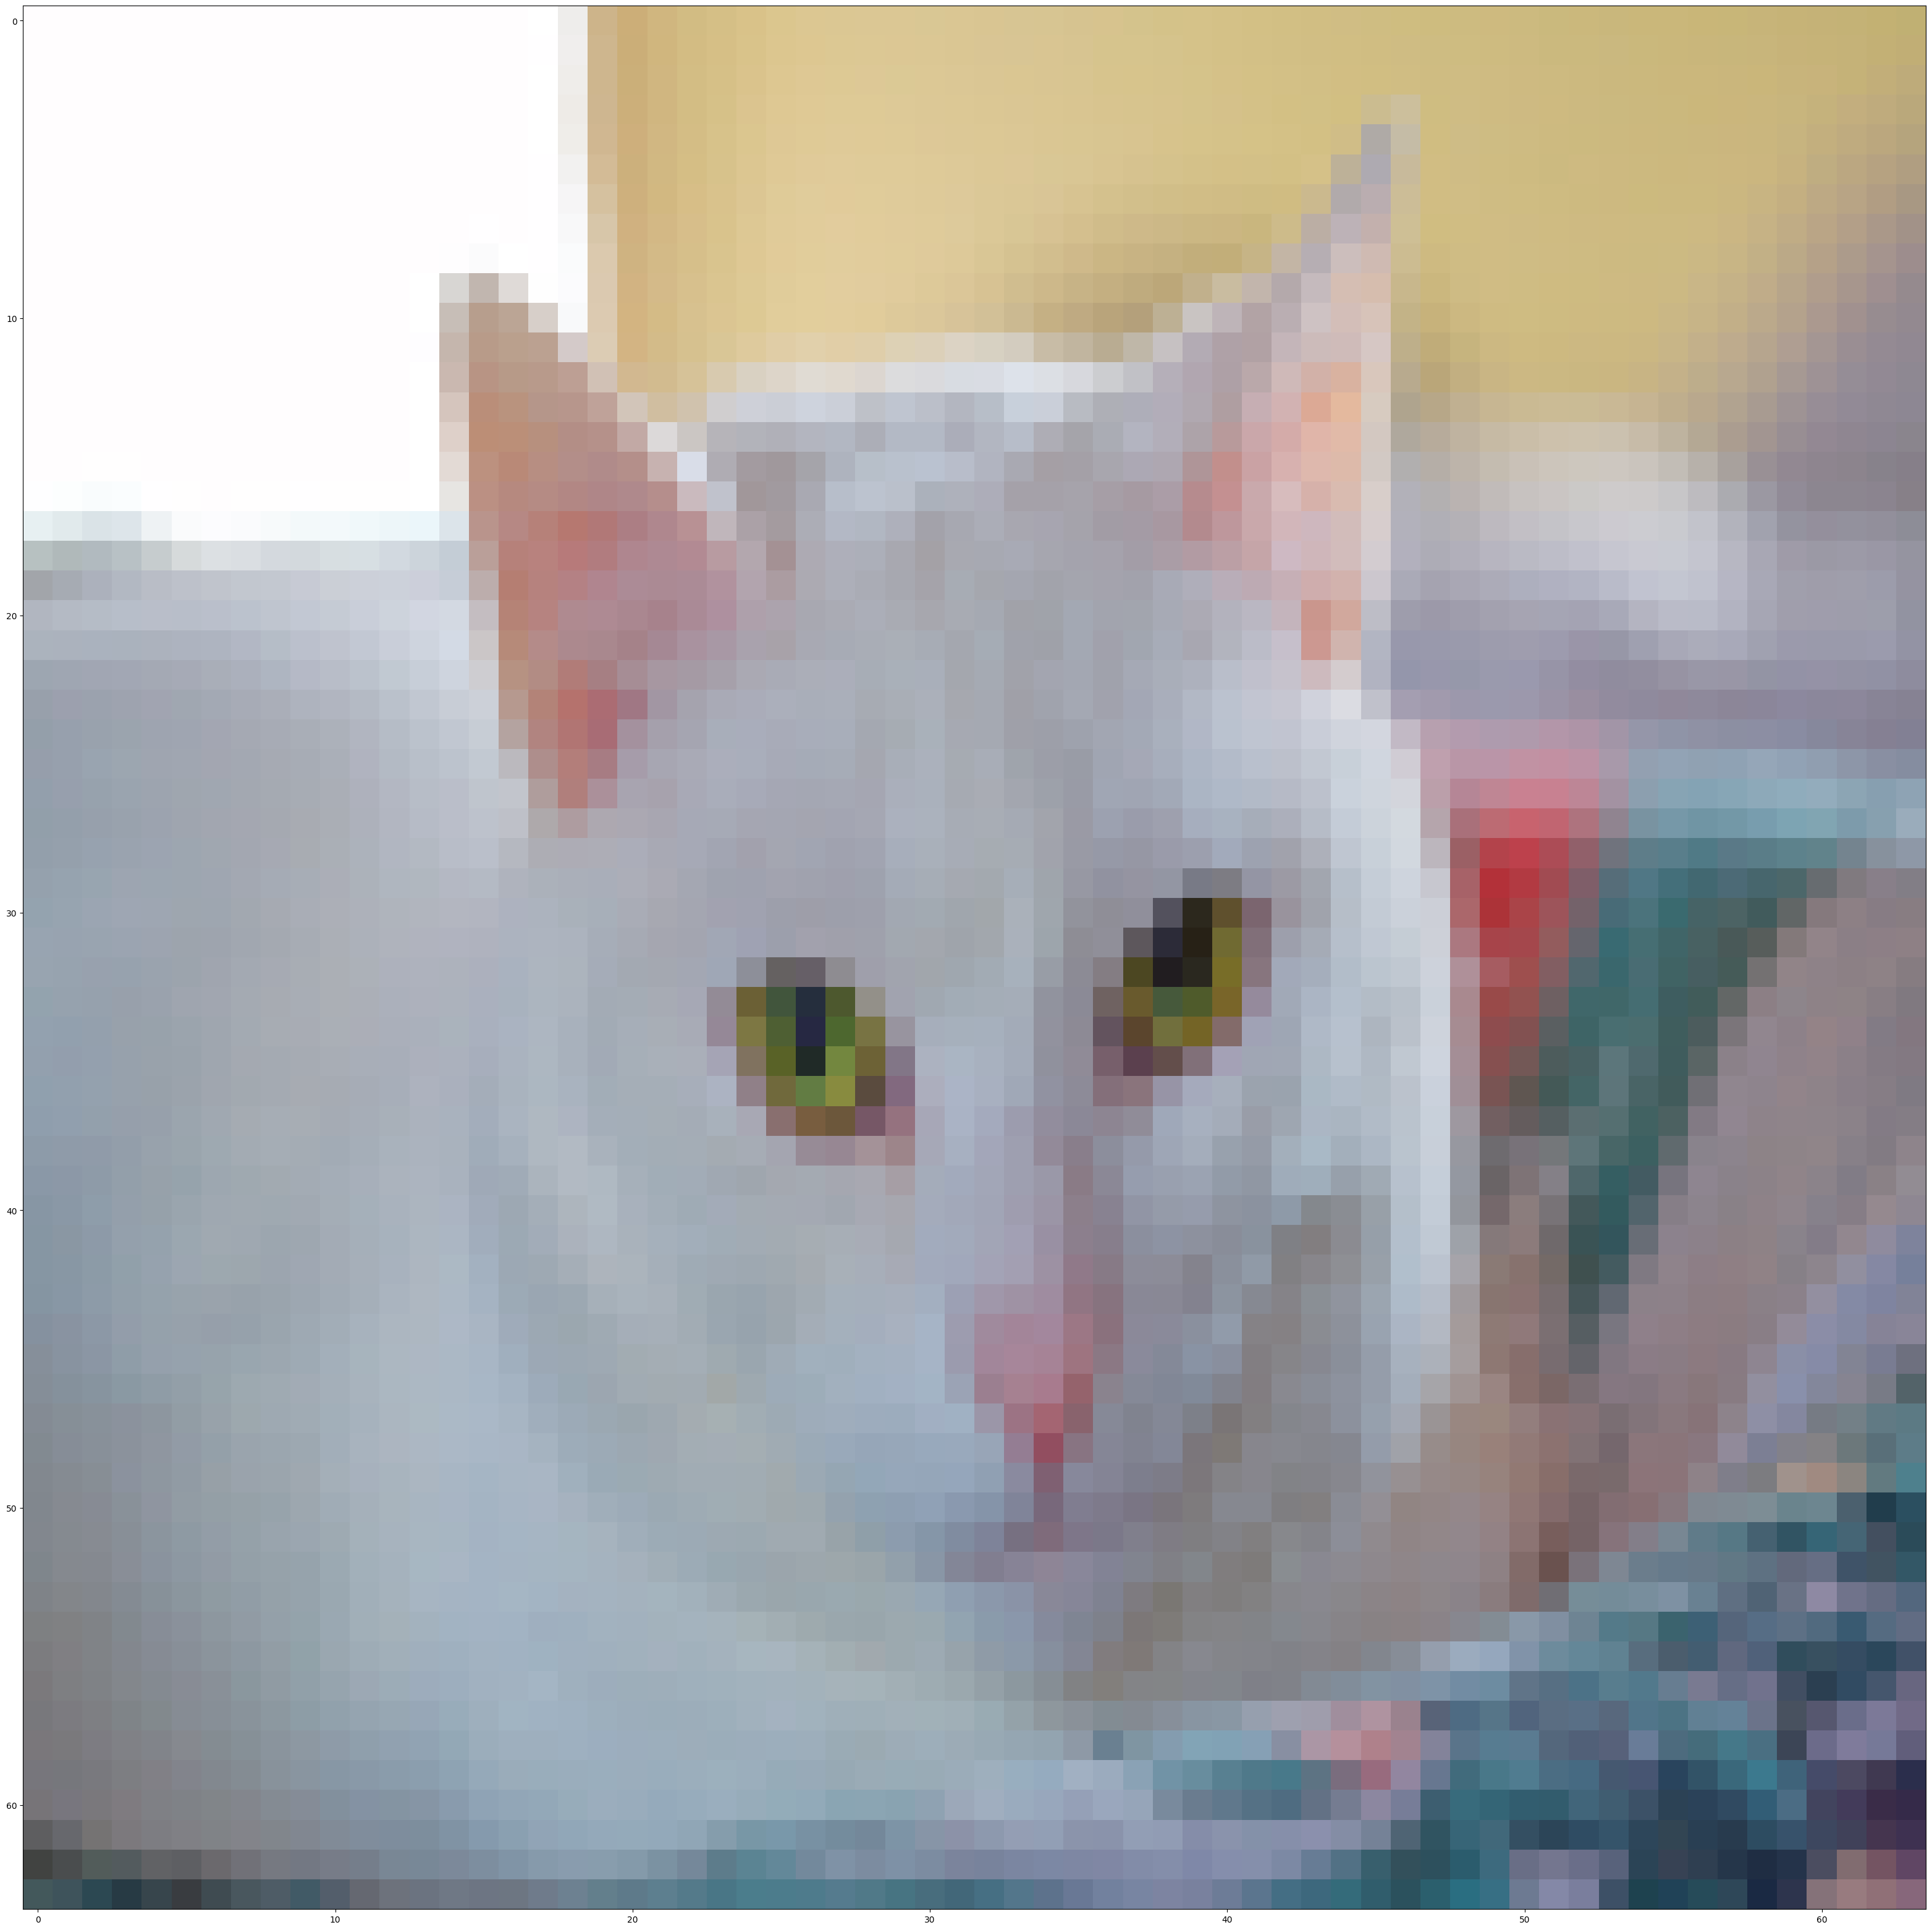

In [17]:
my_image = "my_image.jpg" # 使用自己的测试的文件名
my_label_y = [1] # 图像的标签 (1 -> cat, 0 -> non-cat)

fname = "images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, parameters)


print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")